In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import IPython
from IPython import display
import pylab as pl
from scipy.io import wavfile
import pywt
from brian2 import *
from brian2hears import *

from WSMBSS import *
from general_utils import *
from visualization_utils import * 
from bss_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Sound Separation'

In [2]:
sound_paths = '../../data/Sounds'
sounds = []

rate, a = wavfile.read(os.path.join(sound_paths, 'MA02_04.wav'))
rate, b = wavfile.read(os.path.join(sound_paths, 'MH43_06.wav'))
rate, c = wavfile.read(os.path.join(sound_paths, 'MH43_09.wav'))
rate, d = wavfile.read(os.path.join(sound_paths, 'FA01_03.wav'))
rate, e = wavfile.read(os.path.join(sound_paths, 'FJ55_04.wav'))
rate, f = wavfile.read(os.path.join(sound_paths, 'MD19_07.wav'))
rate, g = wavfile.read(os.path.join(sound_paths, 'MH43_08.wav'))

a = a.astype('float64')
b = b.astype('float64')
c = c.astype('float64')
d = d.astype('float64')
e = e.astype('float64')
f = f.astype('float64')
g = g.astype('float64')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)
f_max = np.max(f)
g_max = np.max(g)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max
f /= f_max
g /= g_max

shortest = min(len(a), len(b), len(c),  len(d),  len(e), len(f), len(g))
a = a[:shortest]#[:,0]
b = b[:shortest]#[:,0]
c = c[:shortest]#[:,0]
d = d[:shortest]
e = e[:shortest]
f = f[:shortest]
g = g[:shortest]

all_sound_data = np.stack((a, b, c, d, e, f, g))

print(all_sound_data.shape)
display_matrix(np.corrcoef(all_sound_data))

(7, 32851)


<IPython.core.display.Math object>

In [3]:
def compute_vectorized_gammatone_of_rows(S, samplerate, n_center_frequencies, time_constant_of_filters = 1.019,
                                         min_freq = 20, max_freq = 20000, power_normalization_in_freq_domain = False):
    n_sources = S.shape[0]
    n_samples = S.shape[1]
    b1 =time_constant_of_filters
    center_frequencies = erbspace(min_freq*Hz, max_freq*Hz, n_center_frequencies)
    
    GammaToneMatrix = np.zeros((n_sources, n_samples * n_center_frequencies))
    
    for jj in range(n_sources):
        gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
        gt_mon = gammatone.process().T
        GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    
    gamma_tone_max = np.abs(GammaToneMatrix).max(axis = 1).reshape(-1,1)
    S = S / gamma_tone_max
    if power_normalization_in_freq_domain:
        for jj in range(n_sources):
            gammatone = Gammatone(Sound(S[jj,:], samplerate = samplerate*Hz), center_frequencies, b=b1)
            gt_mon = gammatone.process().T
            GammaToneMatrix[jj, :] = gt_mon.reshape(-1)
    return GammaToneMatrix, gamma_tone_max

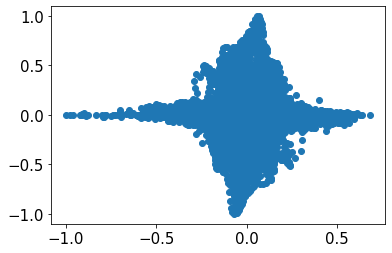

In [4]:
S = all_sound_data[np.random.choice(all_sound_data.shape[0], size=3, replace=False, p=None),:]
nbr_center_frequencies = 10
b1 = 1.019  #factor determining the time constant of the filters

S_gammaTone, S_gammaToneMax = compute_vectorized_gammatone_of_rows(S, samplerate = 16000, 
                                                                   n_center_frequencies = nbr_center_frequencies,
                                                                   time_constant_of_filters = b1, 
                                                                   min_freq = 20, max_freq = 20000, 
                                                                   power_normalization_in_freq_domain = True)
S = S / S_gammaToneMax

plt.scatter(S_gammaTone[0,:], S_gammaTone[1,:])

In [5]:
# np.random.seed(250)
NumberofMixtures = 5
NumberofSources = S.shape[0]

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

# A, X = WSM_Mixing_Scenario(S, NumberofMixtures=NumberofMixtures, INPUT_STD=None)

Xnoisy, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((Xnoisy - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 39.96059460600932
Row standard deviation of mixtures : [0.50879179 0.42113859 0.56153862 0.39757458 0.43313497]


In [6]:
X_gammaTone, _ = compute_vectorized_gammatone_of_rows( X, samplerate = 16000, 
                                                       n_center_frequencies = nbr_center_frequencies,
                                                       time_constant_of_filters = b1, 
                                                       min_freq = 20, max_freq = 20000, 
                                                       power_normalization_in_freq_domain = False)

In [7]:
MUS = 0.4

gammaM_start = [MUS, MUS]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-5
LayerGains = [8, 1]
LayerMinimumGains = [1e-6, 1]
LayerMaximumGains = [1e6, 1.001]
WScalings = [0.0033, 0.0033]
GamScalings = [0.02, 0.02]
zeta = 10 * 1e-5
beta = 0.5
muD = [0.001, 1e-3]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
mixtures_power_normalized = True
# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index"
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "constant"

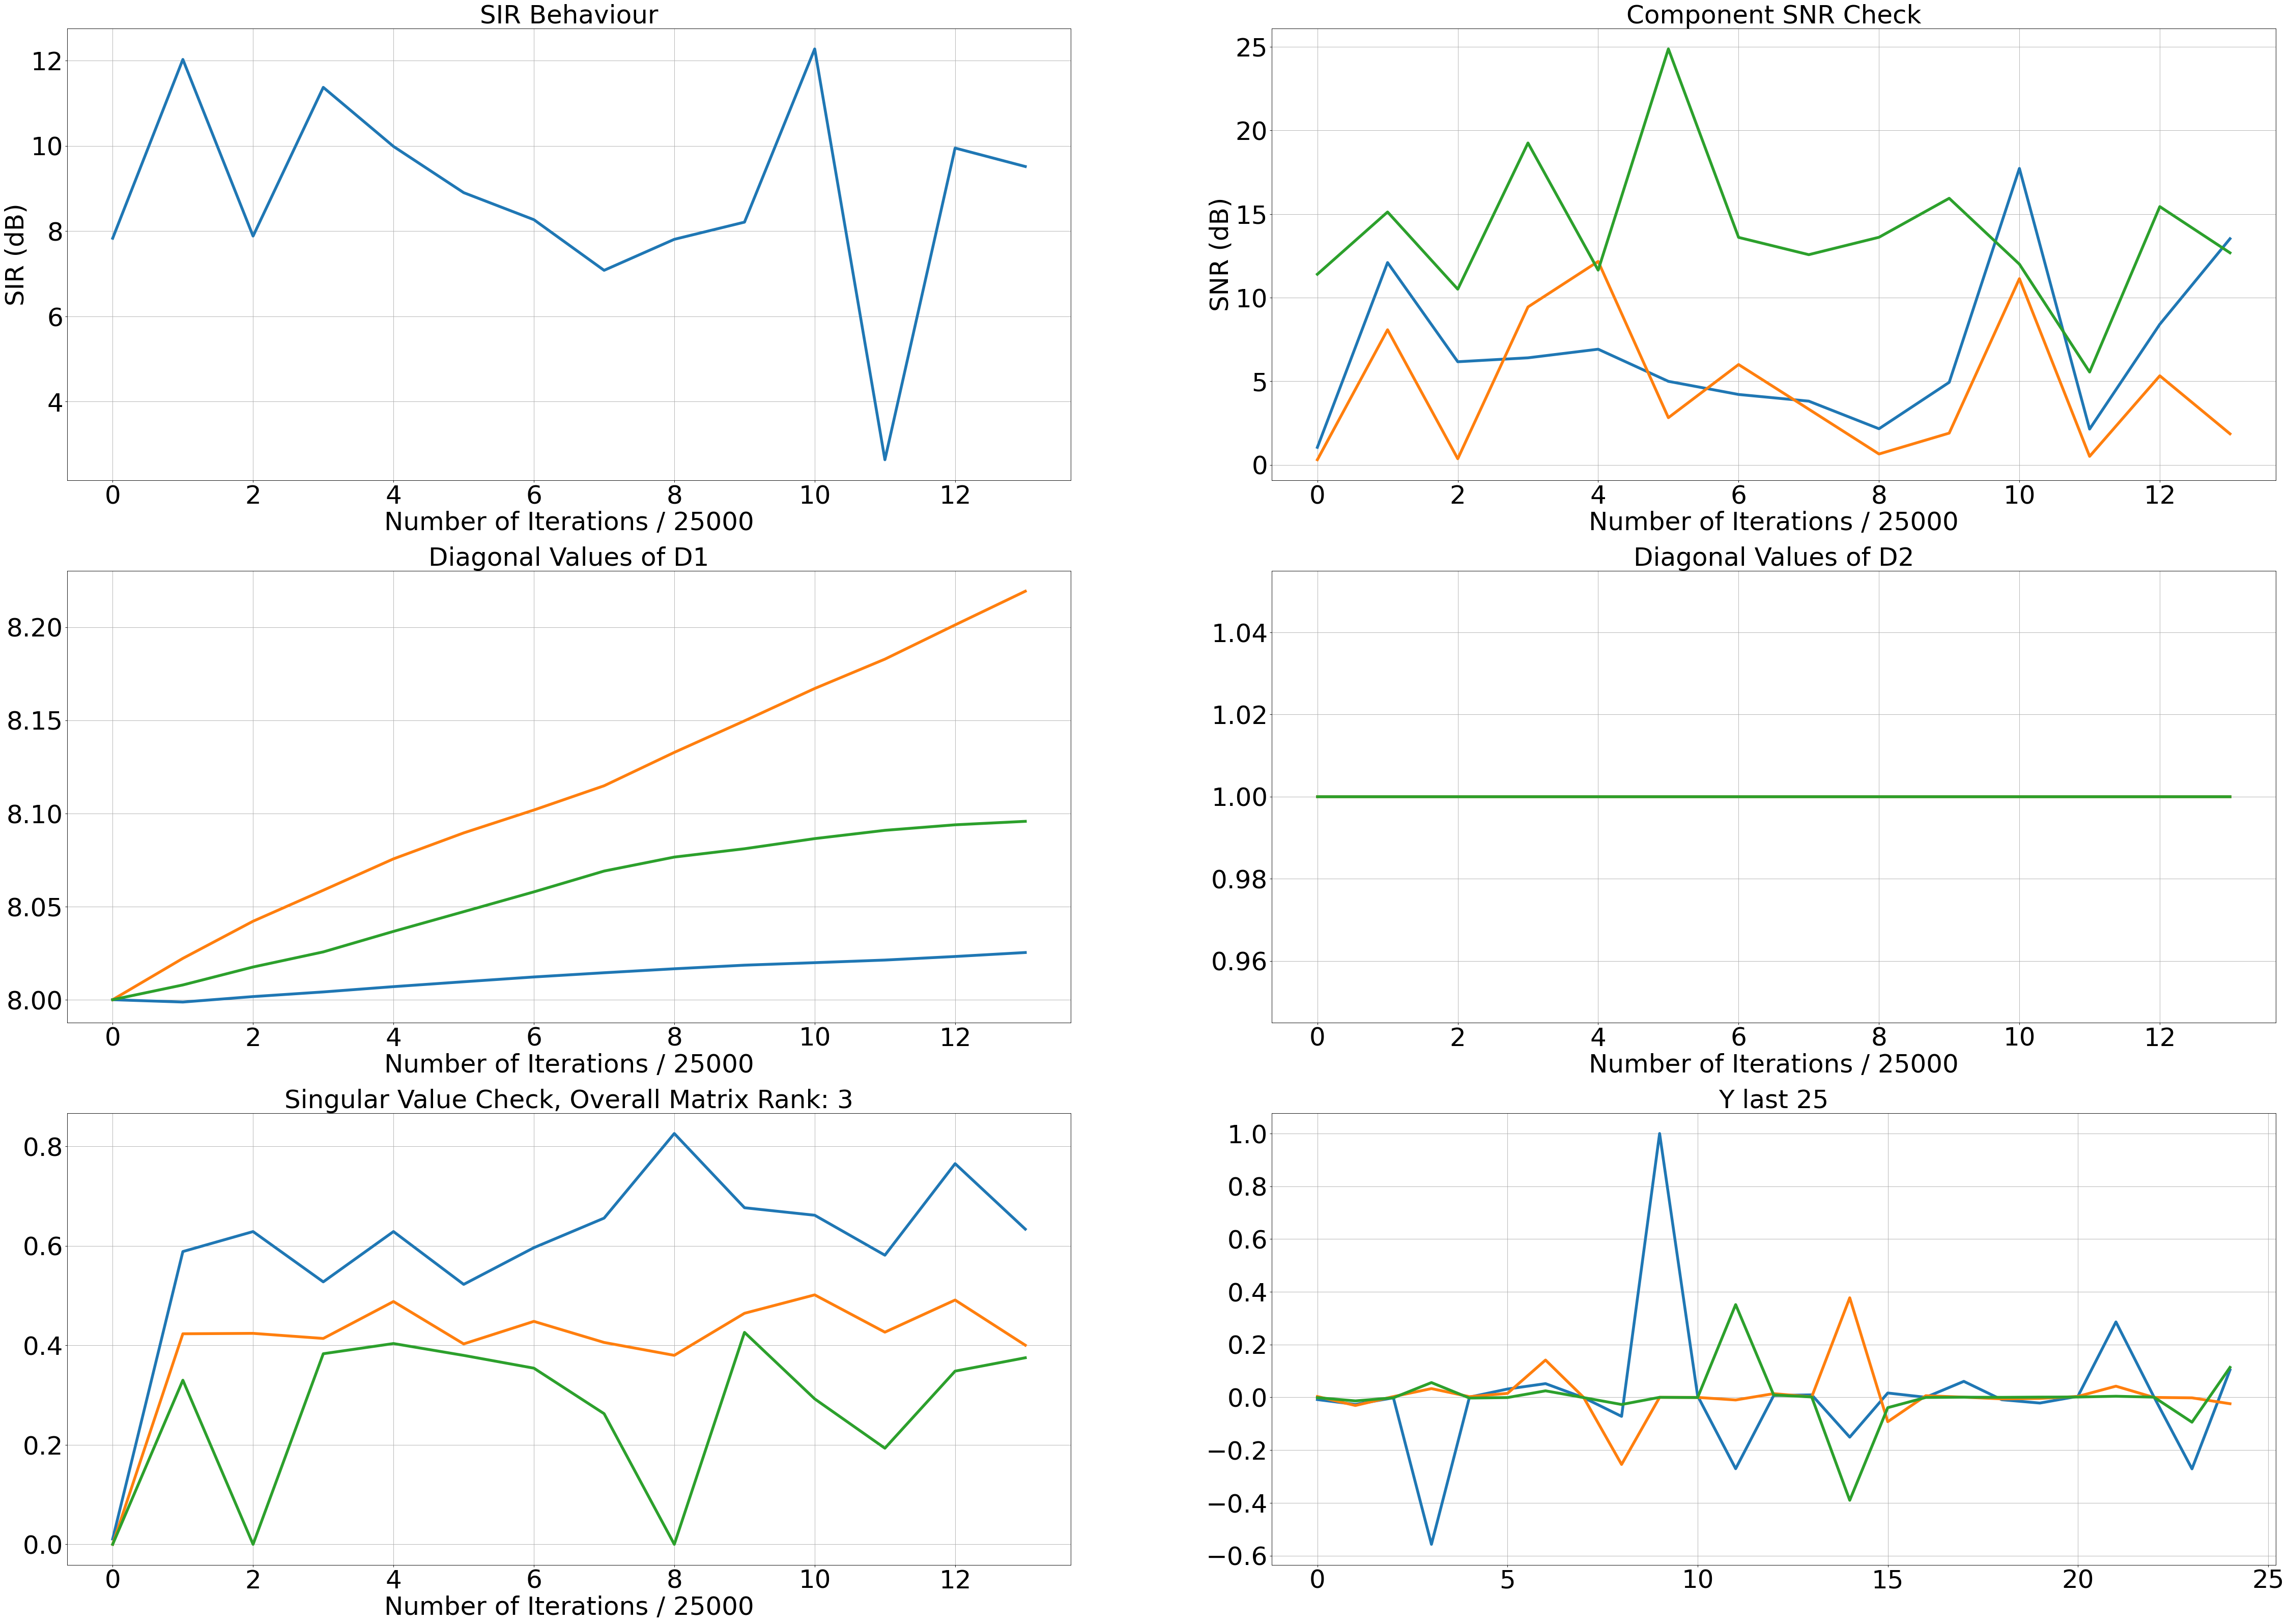

100%|██████████| 328510/328510 [07:40<00:00, 713.93it/s] 


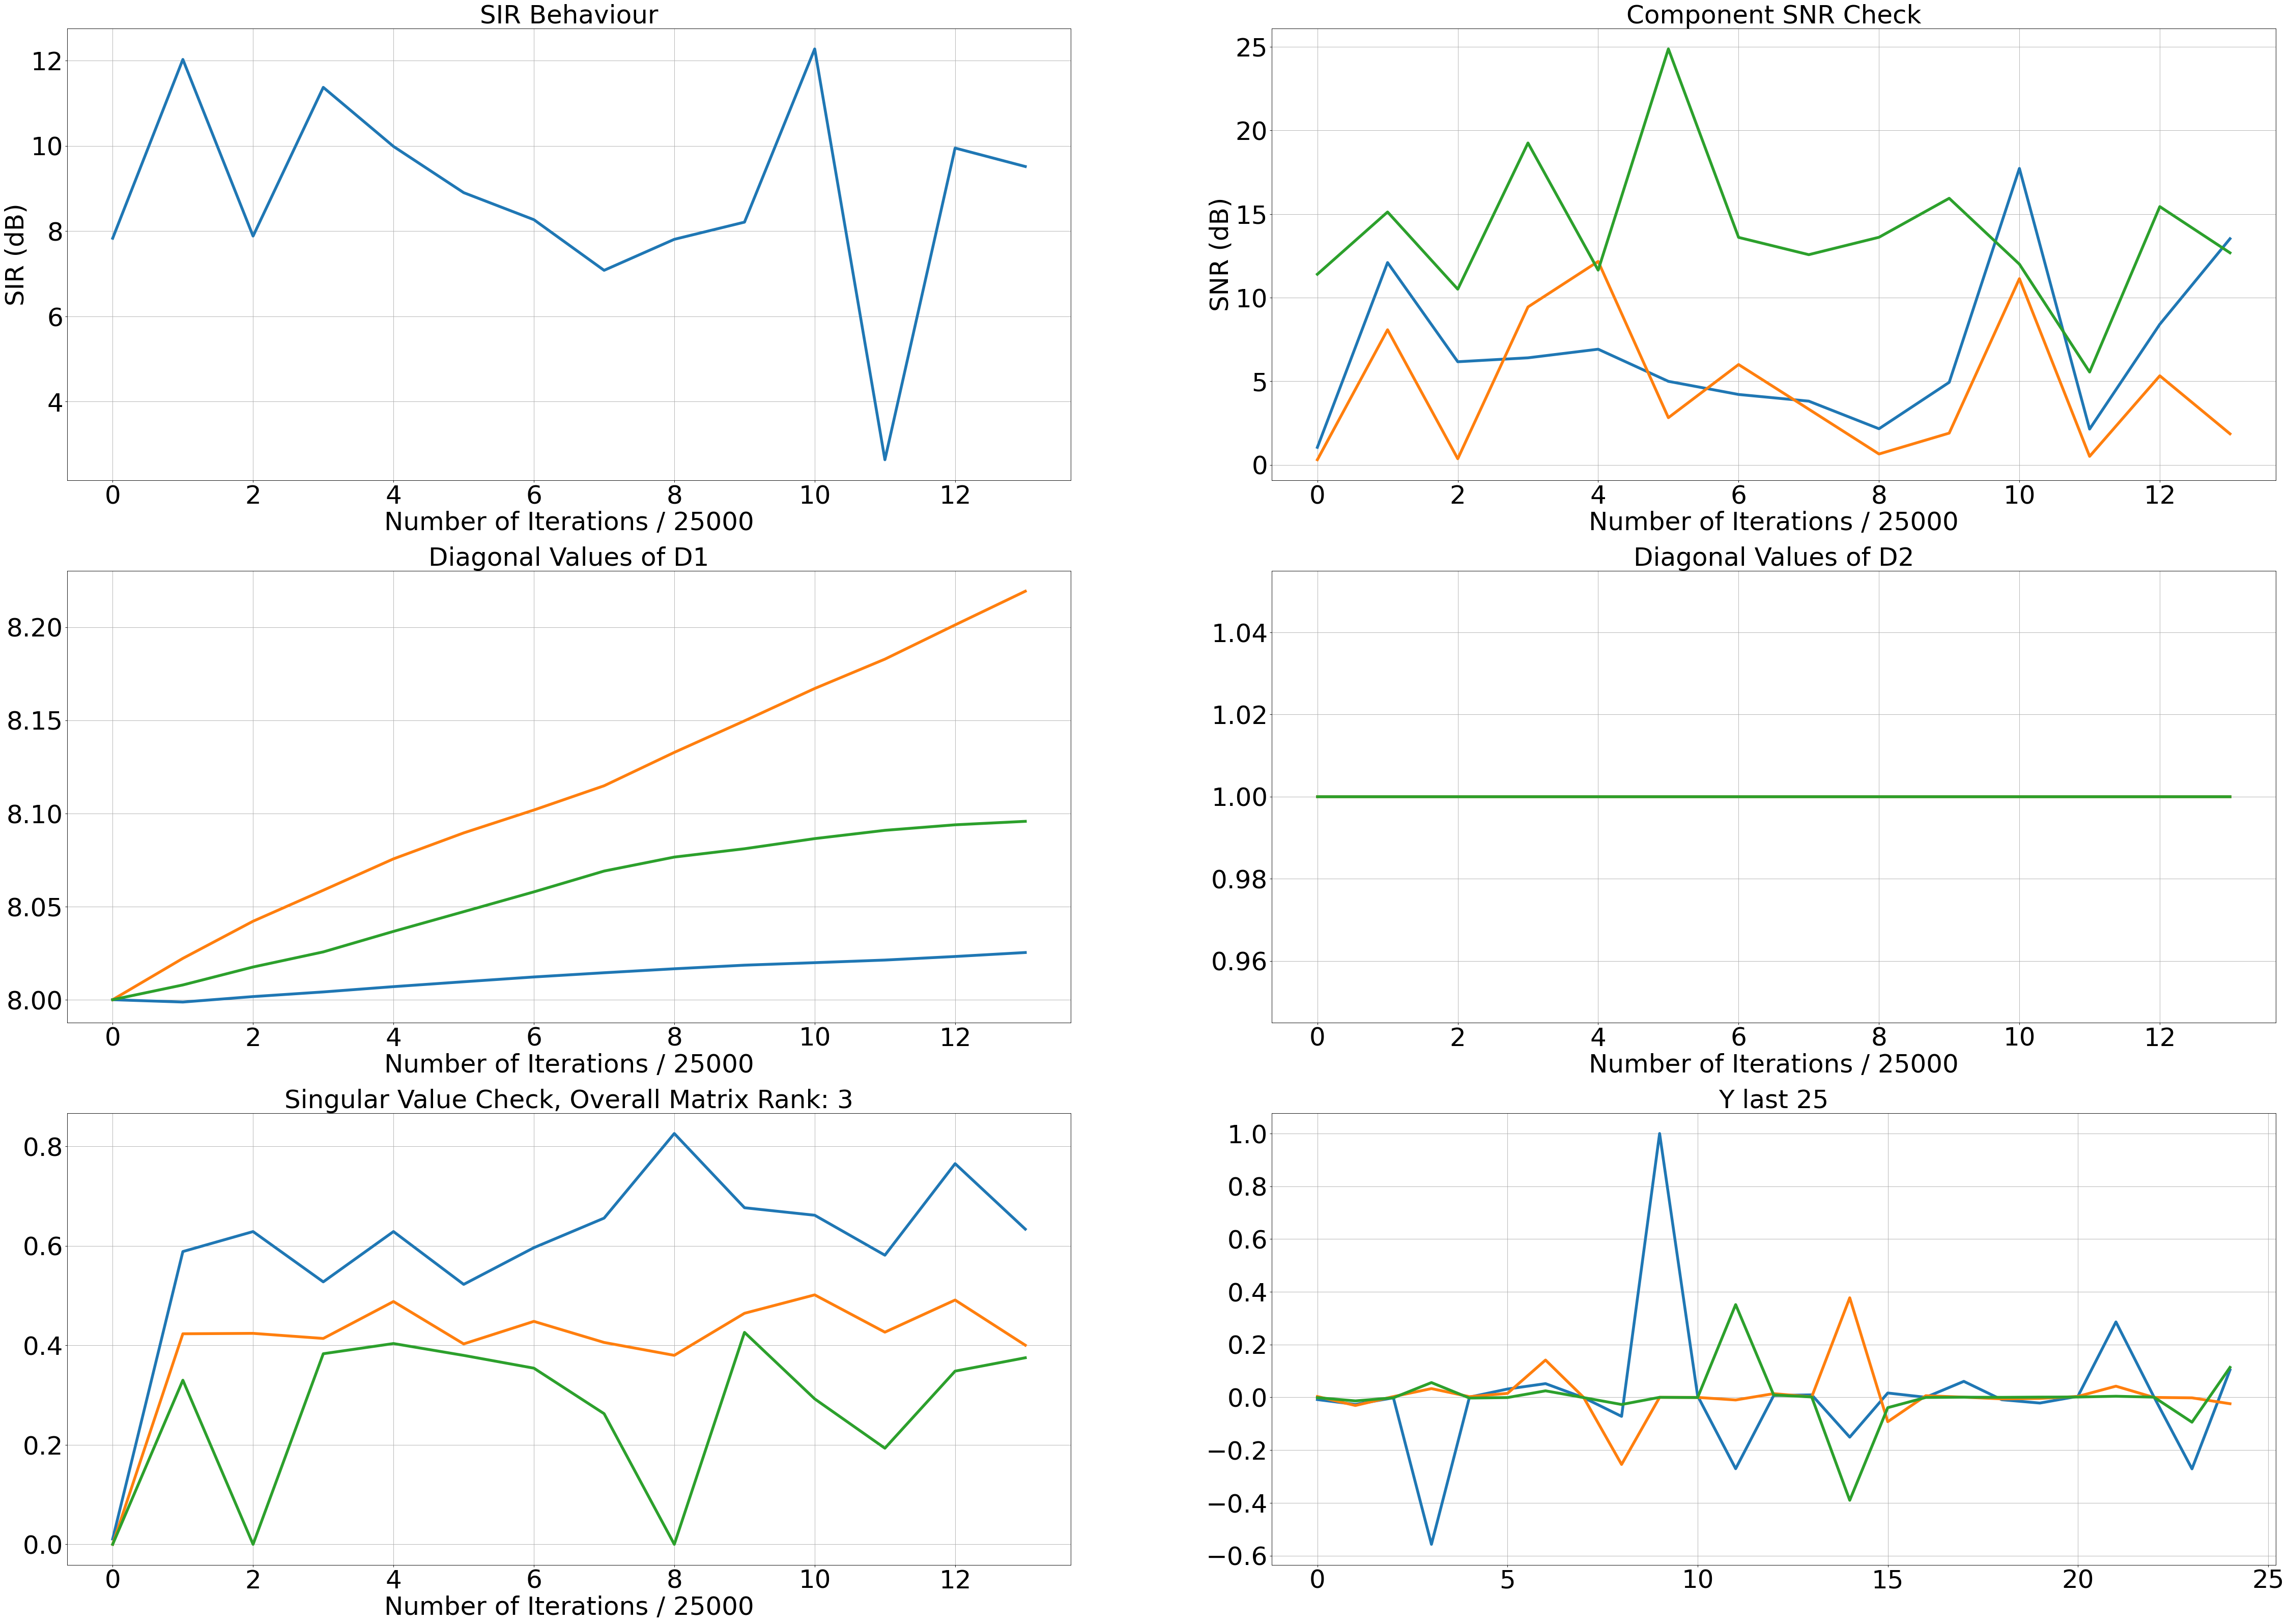

In [8]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(
    s_dim=s_dim,
    x_dim=x_dim,
    h_dim=h_dim,
    gammaM_start=gammaM_start,
    gammaM_stop=gammaM_stop,
    gammaW_start=gammaW_start,
    gammaW_stop=gammaW_stop,
    beta=beta,
    zeta=zeta,
    muD=muD,
    WScalings=WScalings,
    GamScalings=GamScalings,
    DScalings=LayerGains,
    LayerMinimumGains=LayerMinimumGains,
    LayerMaximumGains=LayerMaximumGains,
    neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
    set_ground_truth=True,
    S=S_gammaTone,
    A=A,
)

X_gammaToneWSM = (0.5 * (X_gammaTone / X_gammaTone.std(1)[:,np.newaxis]))
modelWSM.fit_batch_sparse(
    X_gammaToneWSM,
    n_epochs=1,
    neural_lr_start=0.4,
    synaptic_lr_rule=synaptic_lr_rule,
    neural_loop_lr_rule=neural_loop_lr_rule,
    mixtures_power_normalized=mixtures_power_normalized,
    debug_iteration_point=debug_iteration_point,
    shuffle = True,
    plot_in_jupyter=True,
)